In [2]:
import os
from collections import Counter
from pathlib import Path

import anndata
import altair as alt
import pandas as pd
import numpy as np
import scipy
import scanpy as sc
import seaborn as sns
import umap
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler


import mgitools.os_helpers as os_helpers

In [3]:
from pollock.models.model import predict_from_anndata, embed_from_anndata
from pollock.models.explain import explain_predictions

In [4]:
DATA_DIR = '../benchmarking/sandbox/figure_data'
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

###### train model if needed

In [93]:
fp = '/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor1_BM_act.txt'
df = pd.read_csv(fp, sep='\t')
df = df.iloc[:, 1:-1]
df = df.set_index('Gene')
df = df.transpose()
new = fp.replace('.txt', '_fixed.txt')
df.to_csv(new, sep='\t')
adata = sc.read_text(new)
adata.obs['sample'] = fp.split('/')[-1].split('.')[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [95]:
adata.obs

sample
GATCAGTAGGGCTTGA  Donor1_BM_act
GCACTCTGTCGATTGT  Donor1_BM_act
GCGCCAAGTGGTAACG  Donor1_BM_act
TGGCTGGCACAAGTAA  Donor1_BM_act
AAAGTAGGTTGTCGCG  Donor1_BM_act
...                         ...
TTCCCAGTCCATGAAC  Donor1_BM_act
CGTCACTCATGTCTCC  Donor1_BM_act
TATGCCCCAACTGCTA  Donor1_BM_act
TCACAAGTCTGTTTGT  Donor1_BM_act
CTACGTCAGAATAGGG  Donor1_BM_act

[2512 rows x 1 columns]

In [90]:
df

Gene              KLHL11  CTD-3154N5.2  KRT13  SNORD116-21  AGPAT3  \
GATCAGTAGGGCTTGA     0.0           0.0    0.0          0.0     4.0   
GCACTCTGTCGATTGT     0.0           0.0    0.0          0.0     0.0   
GCGCCAAGTGGTAACG     0.0           0.0    0.0          0.0     1.0   
TGGCTGGCACAAGTAA     0.0           0.0    0.0          0.0     2.0   
AAAGTAGGTTGTCGCG     0.0           0.0    0.0          0.0     4.0   
...                  ...           ...    ...          ...     ...   
CGTCACTCATGTCTCC     0.0           0.0    0.0          0.0     0.0   
TATGCCCCAACTGCTA     0.0           0.0    0.0          0.0     0.0   
TCACAAGTCTGTTTGT     0.0           0.0    0.0          0.0     0.0   
CTACGTCAGAATAGGG     0.0           0.0    0.0          0.0     0.0   
Unnamed: 2514        NaN           NaN    NaN          NaN     NaN   

Gene              AC096752.1  C16orf78  AC009531.2  LINC00609  RP11-212D3.2  \
GATCAGTAGGGCTTGA         0.0       0.0         0.0        0.0           0.0   
GCACTCTGTCGATTGT         0.0       0.0         0.0        0.0           0.0   
GCGCCAAGTGGTAACG         0.0       0.0         0.0        0.0           0.0   
TGGCTGGCACAAGTAA         0.0       0.0         0.0        0.0           0.0   
AAAGTAGGTTGTCGCG         0.0       0.0         0.0        0.0           0.0   
...                      ...       ...         ...        ...           ...   
CGTCACTCATGTCTCC         0.0       0.0         0.0        0.0           0.0   
TATGCCCCAACTGCTA         0.0       0.0         0.0        0.0           0.0   
TCACAAGTCTGTTTGT         0.0       0.0         0.0        0.0           0.0   
CTACGTCAGAATAGGG         0.0       0.0         0.0        0.0           0.0   
Unnamed: 2514            NaN       NaN         NaN        NaN           NaN   

Gene              ...  RP11-294J22.5  MXRA5Y  Y_RNA  RP11-706D8.3  HEXA  \
GATCAGTAGGGCTTGA  ...            0.0     0.0    0.0           0.0   0.0   
GCACTCTGTCGATTGT  ...            0.0     0.0    0.0           0.0   0.0   
GCGCCAAGTGGTAACG  ...            0.0     0.0    0.0           0.0   0.0   
TGGCTGGCACAAGTAA  ...            0.0     0.0    0.0           0.0   0.0   
AAAGTAGGTTGTCGCG  ...            0.0     0.0    0.0           0.0   0.0   
...               ...            ...     ...    ...           ...   ...   
CGTCACTCATGTCTCC  ...            0.0     0.0    0.0           0.0   0.0   
TATGCCCCAACTGCTA  ...            0.0     0.0    0.0           0.0   0.0   
TCACAAGTCTGTTTGT  ...            0.0     0.0    0.0           0.0   0.0   
CTACGTCAGAATAGGG  ...            0.0     0.0    0.0           0.0   0.0   
Unnamed: 2514     ...            NaN     NaN    NaN           NaN   NaN   

Gene              RP11-435O5.2  HOXC5  C1orf105  MORF4L1P5  AL138706.1  
GATCAGTAGGGCTTGA           0.0    0.0       0.0        0.0         0.0  
GCACTCTGTCGATTGT           0.0    0.0       0.0        0.0         0.0  
GCGCCAAGTGGTAACG           0.0    0.0       0.0        0.0         0.0  
TGGCTGGCACAAGTAA           0.0    0.0       0.0        0.0         0.0  
AAAGTAGGTTGTCGCG           0.0    0.0       0.0        0.0         0.0  
...                        ...    ...       ...        ...         ...  
CGTCACTCATGTCTCC           0.0    0.0       0.0        0.0         0.0  
TATGCCCCAACTGCTA           0.0    0.0       0.0        0.0         0.0  
TCACAAGTCTGTTTGT           0.0    0.0       0.0        0.0         0.0  
CTACGTCAGAATAGGG           0.0    0.0       0.0        0.0         0.0  
Unnamed: 2514              NaN    NaN       NaN        NaN         NaN  

[2513 rows x 60725 columns]

In [101]:
fps = sorted(os_helpers.listfiles('/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/',
                                 regex='.txt$'))

adatas = []
for fp in fps:
    print(fp)
    df = pd.read_csv(fp, sep='\t')
    df = df.iloc[:, 1:-1]
    df = df.set_index('Gene')
    df = df.transpose()
    new = fp.replace('.txt', '_fixed.txt')
    df.to_csv(new, sep='\t')
    adata = sc.read_text(new)
    adata.obs['sample'] = fp.split('/')[-1].split('.')[0]
    adatas.append(adata)

/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor1_BM_act.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor1_BM_rest.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor1_LG_act.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor1_LG_rest.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor1_LN_act.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor1_LN_rest.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor2_BM_act.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor2_BM_rest.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor2_LG_act.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor2_LG_rest.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor2_LN_act.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/Donor2_LN_rest.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/DonorA_BL_act.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/DonorA_BL_rest.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/DonorB_BL_act.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_RAW/DonorB_BL_rest.txt


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [113]:
for adata in adatas:
    adata.obs['barcode'] = adata.obs.index.to_list()
    adata.obs['id'] = [f'{s}_{b}' for s, b in zip(adata.obs['sample'], adata.obs['barcode'])]
    adata.obs = adata.obs.set_index('id')
    adata.var_names_make_unique()
    

Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3', 'SNORD113-4', 'SNORD113-5']
Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1

In [114]:
adata = anndata.concat(adatas)
adata

AnnData object with n_obs × n_vars = 63861 × 60725
    obs: 'sample', 'barcode'

In [115]:
adata.write_h5ad('/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_raw.h5ad')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sample' as categorical
... storing 'barcode' as categorical


In [117]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [159]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [160]:
metadata = pd.read_csv('/home/estorrs/data/single_cell_classification/hca/T_cell_activation/project_metadata.tsv',
                       sep='\t')
metadata['id'] = [f'{d}_{t}_{s}_{b}' for d, t, s, b in zip(metadata['donor'], metadata['tissue'], metadata['stimulation_status'],
                                       metadata['barcode'])]
metadata = metadata.set_index('id')
metadata

barcode  umap_x  umap_y tissue  \
id                                                                         
Donor1_LG_rest_CAAGATCTCTTGGGTA  CAAGATCTCTTGGGTA   1.690  -1.510     LG   
Donor1_LG_rest_CATCCACGTCACCTAA  CATCCACGTCACCTAA   1.160   0.308     LG   
Donor1_LG_rest_TTGAACGCACTAAGTC  TTGAACGCACTAAGTC   1.120  -1.160     LG   
Donor1_LG_rest_CTACGTCCAAGTACCT  CTACGTCCAAGTACCT   0.614  -0.753     LG   
Donor1_LG_rest_ACTTGTTCATGCCTTC  ACTTGTTCATGCCTTC   0.355  -2.240     LG   
...                                           ...     ...     ...    ...   
DonorB_BL_act_CAACCTCCAGCCAGAA   CAACCTCCAGCCAGAA  -1.510  -3.480     BL   
DonorB_BL_act_CCCATACTCTTAGAGC   CCCATACTCTTAGAGC  -1.610   0.198     BL   
DonorB_BL_act_AGTGTCACATATGAGA   AGTGTCACATATGAGA   0.192  -3.410     BL   
DonorB_BL_act_CGTTGGGAGAGGTTAT   CGTTGGGAGAGGTTAT  -1.140  -3.580     BL   
DonorB_BL_act_ACTGAACTCTGCCAGG   ACTGAACTCTGCCAGG  -1.290  -3.730     BL   

                                  donor stimulation_status cd4cd8_status  \
id                                                                         
Donor1_LG_rest_CAAGATCTCTTGGGTA  Donor1               rest           CD8   
Donor1_LG_rest_CATCCACGTCACCTAA  Donor1               rest           CD8   
Donor1_LG_rest_TTGAACGCACTAAGTC  Donor1               rest           CD8   
Donor1_LG_rest_CTACGTCCAAGTACCT  Donor1               rest           CD4   
Donor1_LG_rest_ACTTGTTCATGCCTTC  Donor1               rest           CD4   
...                                 ...                ...           ...   
DonorB_BL_act_CAACCTCCAGCCAGAA   DonorB                act           CD4   
DonorB_BL_act_CCCATACTCTTAGAGC   DonorB                act           CD4   
DonorB_BL_act_AGTGTCACATATGAGA   DonorB                act           CD4   
DonorB_BL_act_CGTTGGGAGAGGTTAT   DonorB                act           CD4   
DonorB_BL_act_ACTGAACTCTGCCAGG   DonorB                act           CD4   

                                 ccl5_expr_log2(CPT+1)  
id                                                      
Donor1_LG_rest_CAAGATCTCTTGGGTA              12.584882  
Donor1_LG_rest_CATCCACGTCACCTAA              12.407254  
Donor1_LG_rest_TTGAACGCACTAAGTC              12.286985  
Donor1_LG_rest_CTACGTCCAAGTACCT               9.219317  
Donor1_LG_rest_ACTTGTTCATGCCTTC              10.373826  
...                                                ...  
DonorB_BL_act_CAACCTCCAGCCAGAA                0.000000  
DonorB_BL_act_CCCATACTCTTAGAGC                0.000000  
DonorB_BL_act_AGTGTCACATATGAGA                0.000000  
DonorB_BL_act_CGTTGGGAGAGGTTAT                0.000000  
DonorB_BL_act_ACTGAACTCTGCCAGG                0.000000  

[51876 rows x 8 columns]

In [161]:
adata.obs

sample         barcode_x  \
id                                                                  
Donor1_LG_rest_CAAGATCTCTTGGGTA  Donor1_LG_rest  CAAGATCTCTTGGGTA   
Donor1_LG_rest_CATCCACGTCACCTAA  Donor1_LG_rest  CATCCACGTCACCTAA   
Donor1_LG_rest_TTGAACGCACTAAGTC  Donor1_LG_rest  TTGAACGCACTAAGTC   
Donor1_LG_rest_CTACGTCCAAGTACCT  Donor1_LG_rest  CTACGTCCAAGTACCT   
Donor1_LG_rest_ACTTGTTCATGCCTTC  Donor1_LG_rest  ACTTGTTCATGCCTTC   
...                                         ...               ...   
DonorB_BL_act_CAACCTCCAGCCAGAA    DonorB_BL_act  CAACCTCCAGCCAGAA   
DonorB_BL_act_CCCATACTCTTAGAGC    DonorB_BL_act  CCCATACTCTTAGAGC   
DonorB_BL_act_AGTGTCACATATGAGA    DonorB_BL_act  AGTGTCACATATGAGA   
DonorB_BL_act_CGTTGGGAGAGGTTAT    DonorB_BL_act  CGTTGGGAGAGGTTAT   
DonorB_BL_act_ACTGAACTCTGCCAGG    DonorB_BL_act  ACTGAACTCTGCCAGG   

                                 n_genes_by_counts  total_counts  \
id                                                                 
Donor1_LG_rest_CAAGATCTCTTGGGTA               2754        9780.0   
Donor1_LG_rest_CATCCACGTCACCTAA               2676        8021.0   
Donor1_LG_rest_TTGAACGCACTAAGTC               1933        7692.0   
Donor1_LG_rest_CTACGTCCAAGTACCT               2096        7496.0   
Donor1_LG_rest_ACTTGTTCATGCCTTC               2100        6850.0   
...                                            ...           ...   
DonorB_BL_act_CAACCTCCAGCCAGAA                 465        1121.0   
DonorB_BL_act_CCCATACTCTTAGAGC                 471        1115.0   
DonorB_BL_act_AGTGTCACATATGAGA                 526        1053.0   
DonorB_BL_act_CGTTGGGAGAGGTTAT                 460        1041.0   
DonorB_BL_act_ACTGAACTCTGCCAGG                 544        1016.0   

                                 total_counts_mt  pct_counts_mt  \
id                                                                
Donor1_LG_rest_CAAGATCTCTTGGGTA            273.0       2.791411   
Donor1_LG_rest_CATCCACGTCACCTAA            241.0       3.004613   
Donor1_LG_rest_TTGAACGCACTAAGTC            209.0       2.717109   
Donor1_LG_rest_CTACGTCCAAGTACCT            224.0       2.988261   
Donor1_LG_rest_ACTTGTTCATGCCTTC            130.0       1.897810   
...                                          ...            ...   
DonorB_BL_act_CAACCTCCAGCCAGAA               7.0       0.624442   
DonorB_BL_act_CCCATACTCTTAGAGC               8.0       0.717489   
DonorB_BL_act_AGTGTCACATATGAGA               0.0       0.000000   
DonorB_BL_act_CGTTGGGAGAGGTTAT               1.0       0.096061   
DonorB_BL_act_ACTGAACTCTGCCAGG               2.0       0.196850   

                                        barcode_y  umap_x  umap_y tissue  ...  \
id                                                                        ...   
Donor1_LG_rest_CAAGATCTCTTGGGTA  CAAGATCTCTTGGGTA   1.690  -1.510     LG  ...   
Donor1_LG_rest_CATCCACGTCACCTAA  CATCCACGTCACCTAA   1.160   0.308     LG  ...   
Donor1_LG_rest_TTGAACGCACTAAGTC  TTGAACGCACTAAGTC   1.120  -1.160     LG  ...   
Donor1_LG_rest_CTACGTCCAAGTACCT  CTACGTCCAAGTACCT   0.614  -0.753     LG  ...   
Donor1_LG_rest_ACTTGTTCATGCCTTC  ACTTGTTCATGCCTTC   0.355  -2.240     LG  ...   
...                                           ...     ...     ...    ...  ...   
DonorB_BL_act_CAACCTCCAGCCAGAA   CAACCTCCAGCCAGAA  -1.510  -3.480     BL  ...   
DonorB_BL_act_CCCATACTCTTAGAGC   CCCATACTCTTAGAGC  -1.610   0.198     BL  ...   
DonorB_BL_act_AGTGTCACATATGAGA   AGTGTCACATATGAGA   0.192  -3.410     BL  ...   
DonorB_BL_act_CGTTGGGAGAGGTTAT   CGTTGGGAGAGGTTAT  -1.140  -3.580     BL  ...   
DonorB_BL_act_ACTGAACTCTGCCAGG   ACTGAACTCTGCCAGG  -1.290  -3.730     BL  ...   

                                cd4cd8_status ccl5_expr_log2(CPT+1) leiden  \
id                                                                           
Donor1_LG_rest_CAAGATCTCTTGGGTA           CD8             12.584882      6   
Donor1_LG_rest_CATCCACGTCACCTAA           CD8             12.407254      6   
Donor1_LG_rest_TTGAA

In [126]:
adata = adata[metadata.index]
adata.obs = pd.merge(adata.obs, metadata, left_index=True, right_index=True).loc[metadata.index]
adata

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 51876 × 2999
    obs: 'sample', 'barcode_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'barcode_y', 'umap_x', 'umap_y', 'tissue', 'donor', 'stimulation_status', 'cd4cd8_status', 'ccl5_expr_log2(CPT+1)'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [128]:
adata.obsm['paper_umap'] = np.asarray([adata.obs['umap_x'], adata.obs['umap_y']]).transpose()

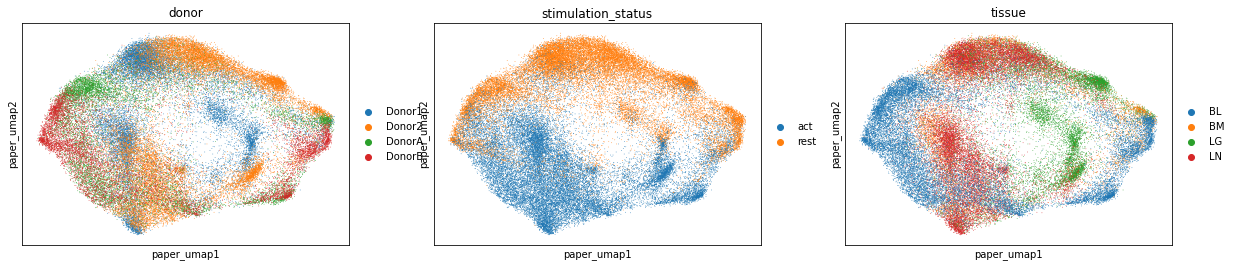

In [130]:
sc.pl.embedding(adata, basis='paper_umap', color=['donor', 'stimulation_status', 'tissue'])

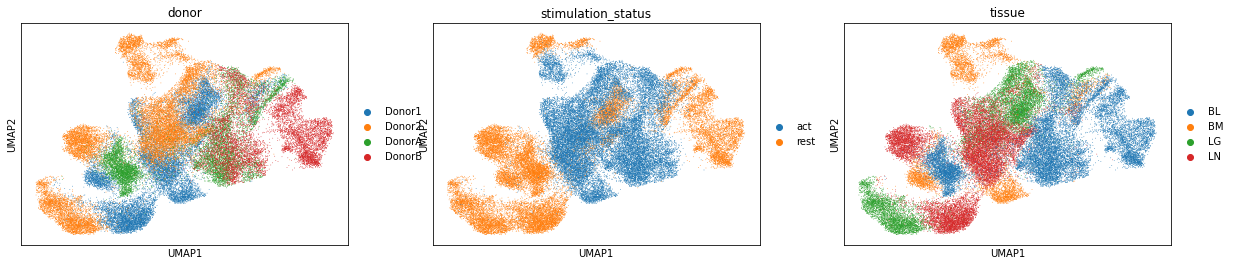

In [162]:
sc.pl.umap(adata, color=['donor', 'stimulation_status', 'tissue'])

In [200]:
sc.tl.leiden(adata, resolution=3.)

In [139]:
df = pd.read_csv('/home/estorrs/data/single_cell_classification/hca/T_cell_activation/t_cell_state_modules.txt',
                sep='\t')
cols = df.iloc[0, :]
df = df.iloc[1:, :]
df.columns = cols
df

0     Treg    CD4 NV/CM  CD4/CD8 IFN Response Proliferation CD8 Cytotoxic  \
1   LRRC32  CTB-133G6.1    WDR86        IFIT3         PYCR1          CCL5   
2     RGS1      TMEM45B     IL7R        CMPK2           NPW          GZMK   
3    FOXP3          AK5   TSPAN2        IFIT2           LIF          GNLY   
4   RNF207          NOG    LRRC2       IFI44L           IL2         TRGC2   
5    CTLA4      NGFRAP1    SNAI3         GBP1       SLC29A1        FGFBP2   
..     ...          ...      ...          ...           ...           ...   
66   NTRK2         IL24    ITGB7         RTP4        SH2D4A        SETBP1   
67  FAM46C        PLCL1    ACSF2        APOL2          YRDC      COLGALT2   
68   KLHL5       LETMD1  ATXN7L1          LPP       C10orf2       KIR2DL4   
69  IZUMO4       SLC8B1    PINK1        SP110         TRAP1        FKBP1B   
70    TFEB        ITGA6    PDCD4      FAM19A2        TIMM8A        ADGRG1   

0  CD8 Cytokine  
1          CCL3  
2        CCL3L3  
3        CCL4L2  
4          IFNG  
5          CCL4  
..          ...  
66        PRDM1  
67        KLRD1  
68      ST8SIA4  
69         IER3  
70         PLEK  

[70 rows x 7 columns]

In [149]:
for c in df.columns:
    genes = df[c].to_list()
    small = adata[:, [g for g in genes if g in adata.var.index]]
    adata.obs[f'{c} score'] = np.mean(small.X, axis=1)

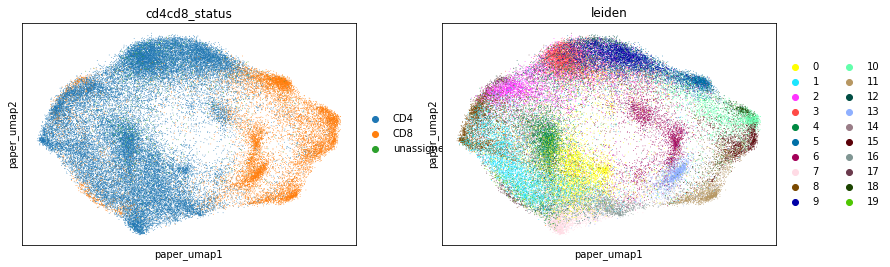

In [196]:
sc.pl.embedding(adata, basis='paper_umap', color=['cd4cd8_status', 'leiden'])

In [205]:
# remove unassigned
adata = adata[[True if 'unassigned' not in c else False for c in adata.obs['cd4cd8_status']]]

In [41]:
clusters = {
    'Treg': ['18'],
#     'CD4 Naive/CM': ['39', '3', '16', '0', '43', '28', '25', '1', '4', '34'],
#     'CD4/CD8': ['13', '38'],
#     'CD8 IFN Response': ['19', '15', '9'],
#     'CD4 IFN Response': ['8', '26', '32', '2', '23', '41', '14'],
    'CD4/CD8 Proliferating': ['7'],
#     'CD8 Cytotoxic': ['40', '33', '36', '30', '25', '35', '21'],
#     'CD8 Cytokine': ['10', '15', '17', '37'] 
}
c2t = {v:k for k, vs in clusters.items() for v in vs}
adata.obs['cell_type'] = [c2t.get(c, f'{t}_{s}') for c, t, s in zip(adata.obs['leiden'], adata.obs['cd4cd8_status'],
                                                                   adata.obs['stimulation_status'])]

... storing 'cell_type' as categorical


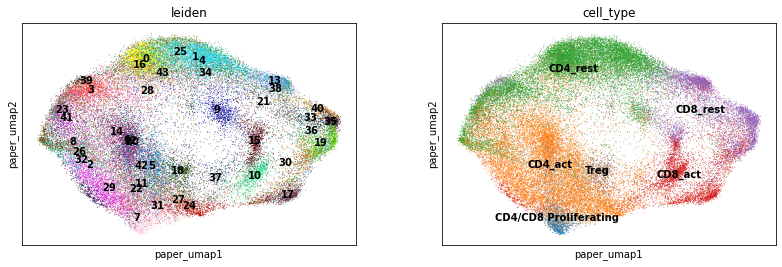

In [42]:
sc.pl.embedding(adata, basis='paper_umap', color=['leiden', 'cell_type'], legend_loc='on data')

In [43]:
adata.write_h5ad('/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_processed.h5ad')

In [38]:
adata = sc.read_h5ad('/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_processed.h5ad')

In [44]:
adata

AnnData object with n_obs × n_vars = 50950 × 2999
    obs: 'sample', 'barcode_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'barcode_y', 'umap_x', 'umap_y', 'tissue', 'donor', 'stimulation_status', 'cd4cd8_status', 'ccl5_expr_log2(CPT+1)', 'leiden', 'Treg score', 'CD4 NV/CM score', 'CD4/CD8 score', 'IFN Response score', 'Proliferation score', 'CD8 Cytotoxic score', 'CD8 Cytokine score', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cd4cd8_status_colors', 'donor_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'stimulation_status_colors', 'tissue_colors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'paper_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [45]:
counts_adata = sc.read_h5ad('/home/estorrs/data/single_cell_classification/hca/T_cell_activation/GSE126030_raw.h5ad')
counts_adata

AnnData object with n_obs × n_vars = 63861 × 60725
    obs: 'sample', 'barcode'

In [46]:
counts_adata = counts_adata[adata.obs.index]
counts_adata.obs = adata.obs
counts_adata

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 50950 × 60725
    obs: 'sample', 'barcode_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'barcode_y', 'umap_x', 'umap_y', 'tissue', 'donor', 'stimulation_status', 'cd4cd8_status', 'ccl5_expr_log2(CPT+1)', 'leiden', 'Treg score', 'CD4 NV/CM score', 'CD4/CD8 score', 'IFN Response score', 'Proliferation score', 'CD8 Cytotoxic score', 'CD8 Cytokine score', 'cell_type'

In [47]:
adata.obs

sample         barcode_x  \
id                                                                  
Donor1_LG_rest_CAAGATCTCTTGGGTA  Donor1_LG_rest  CAAGATCTCTTGGGTA   
Donor1_LG_rest_CATCCACGTCACCTAA  Donor1_LG_rest  CATCCACGTCACCTAA   
Donor1_LG_rest_TTGAACGCACTAAGTC  Donor1_LG_rest  TTGAACGCACTAAGTC   
Donor1_LG_rest_CTACGTCCAAGTACCT  Donor1_LG_rest  CTACGTCCAAGTACCT   
Donor1_LG_rest_ACTTGTTCATGCCTTC  Donor1_LG_rest  ACTTGTTCATGCCTTC   
...                                         ...               ...   
DonorB_BL_act_CAACCTCCAGCCAGAA    DonorB_BL_act  CAACCTCCAGCCAGAA   
DonorB_BL_act_CCCATACTCTTAGAGC    DonorB_BL_act  CCCATACTCTTAGAGC   
DonorB_BL_act_AGTGTCACATATGAGA    DonorB_BL_act  AGTGTCACATATGAGA   
DonorB_BL_act_CGTTGGGAGAGGTTAT    DonorB_BL_act  CGTTGGGAGAGGTTAT   
DonorB_BL_act_ACTGAACTCTGCCAGG    DonorB_BL_act  ACTGAACTCTGCCAGG   

                                 n_genes_by_counts  total_counts  \
id                                                                 
Donor1_LG_rest_CAAGATCTCTTGGGTA               2754        9780.0   
Donor1_LG_rest_CATCCACGTCACCTAA               2676        8021.0   
Donor1_LG_rest_TTGAACGCACTAAGTC               1933        7692.0   
Donor1_LG_rest_CTACGTCCAAGTACCT               2096        7496.0   
Donor1_LG_rest_ACTTGTTCATGCCTTC               2100        6850.0   
...                                            ...           ...   
DonorB_BL_act_CAACCTCCAGCCAGAA                 465        1121.0   
DonorB_BL_act_CCCATACTCTTAGAGC                 471        1115.0   
DonorB_BL_act_AGTGTCACATATGAGA                 526        1053.0   
DonorB_BL_act_CGTTGGGAGAGGTTAT                 460        1041.0   
DonorB_BL_act_ACTGAACTCTGCCAGG                 544        1016.0   

                                 total_counts_mt  pct_counts_mt  \
id                                                                
Donor1_LG_rest_CAAGATCTCTTGGGTA            273.0       2.791411   
Donor1_LG_rest_CATCCACGTCACCTAA            241.0       3.004613   
Donor1_LG_rest_TTGAACGCACTAAGTC            209.0       2.717109   
Donor1_LG_rest_CTACGTCCAAGTACCT            224.0       2.988261   
Donor1_LG_rest_ACTTGTTCATGCCTTC            130.0       1.897810   
...                                          ...            ...   
DonorB_BL_act_CAACCTCCAGCCAGAA               7.0       0.624442   
DonorB_BL_act_CCCATACTCTTAGAGC               8.0       0.717489   
DonorB_BL_act_AGTGTCACATATGAGA               0.0       0.000000   
DonorB_BL_act_CGTTGGGAGAGGTTAT               1.0       0.096061   
DonorB_BL_act_ACTGAACTCTGCCAGG               2.0       0.196850   

                                        barcode_y  umap_x  umap_y tissue  ...  \
id                                                                        ...   
Donor1_LG_rest_CAAGATCTCTTGGGTA  CAAGATCTCTTGGGTA   1.690  -1.510     LG  ...   
Donor1_LG_rest_CATCCACGTCACCTAA  CATCCACGTCACCTAA   1.160   0.308     LG  ...   
Donor1_LG_rest_TTGAACGCACTAAGTC  TTGAACGCACTAAGTC   1.120  -1.160     LG  ...   
Donor1_LG_rest_CTACGTCCAAGTACCT  CTACGTCCAAGTACCT   0.614  -0.753     LG  ...   
Donor1_LG_rest_ACTTGTTCATGCCTTC  ACTTGTTCATGCCTTC   0.355  -2.240     LG  ...   
...                                           ...     ...     ...    ...  ...   
DonorB_BL_act_CAACCTCCAGCCAGAA   CAACCTCCAGCCAGAA  -1.510  -3.480     BL  ...   
DonorB_BL_act_CCCATACTCTTAGAGC   CCCATACTCTTAGAGC  -1.610   0.198     BL  ...   
DonorB_BL_act_AGTGTCACATATGAGA   AGTGTCACATATGAGA   0.192  -3.410     BL  ...   
DonorB_BL_act_CGTTGGGAGAGGTTAT   CGTTGGGAGAGGTTAT  -1.140  -3.580     BL  ...   
DonorB_BL_act_ACTGAACTCTGCCAGG   ACTGAACTCTGCCAGG  -1.290  -3.730     BL  ...   

                                ccl5_expr_log2(CPT+1) leiden Treg score  \
id                                                                        
Donor1_LG_rest_CAAGATCTCTTGGGTA             12.584882     15   0.153181   
Donor1_LG_rest_CATCCACGTCACCTAA             12.407254      9  -0.035955   
Donor1_LG_rest_TTGAACGCACTAAGTC 

In [48]:
from collections import Counter
from pollock.models.model import PollockDataset, PollockModel, balancedish_training_generator

In [49]:
Counter(counts_adata.obs['cell_type'])

Counter({'CD8_rest': 7113,
         'CD4_rest': 17653,
         'Treg': 1179,
         'CD4/CD8 Proliferating': 1625,
         'CD4_act': 16891,
         'CD8_act': 6489})

In [50]:
train, rest = balancedish_training_generator(counts_adata, 'cell_type', n_per_cell_type=1200, split=1.)
train

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 6751 × 60725
    obs: 'sample', 'barcode_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'barcode_y', 'umap_x', 'umap_y', 'tissue', 'donor', 'stimulation_status', 'cd4cd8_status', 'ccl5_expr_log2(CPT+1)', 'leiden', 'Treg score', 'CD4 NV/CM score', 'CD4/CD8 score', 'IFN Response score', 'Proliferation score', 'CD8 Cytotoxic score', 'CD8 Cytokine score', 'cell_type'

In [51]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=1000,
                    oversample=True, dataset_type='training', )

2021-01-05 17:59:55,204 input dataset shape: (6751, 60725)
2021-01-05 17:59:55,206 possible cell types: ['CD4/CD8 Proliferating', 'CD4_act', 'CD4_rest', 'CD8_act', 'CD8_rest', 'Treg']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [52]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.005, latent_dim=25, )

In [53]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:00:19,165 epoch: 1, train loss: 53.09037399291992, val loss: 37.653076171875
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:00:37,643 epoch: 2, train loss: 52.680397033691406, val loss: 37.52842712402344
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:00:55,979 epoch: 3, train loss: 52.31577682495117, val loss: 37.44938278198242
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype in

In [54]:
module_fp = '/home/estorrs/data/single_cell_classification/hca/T_cell_activation/pollock_model'
pm.save(pds, module_fp)

metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.


Text(32.09375, 0.5, 'Groundtruth')

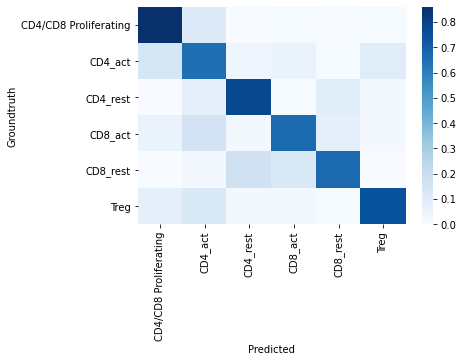

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [56]:
# adata = sc.read_h5ad('../benchmarking/data/11302020_harmonized/teir_2/snRNAseq/ccrcc.h5ad')

In [57]:
data_dir = '../benchmarking/data/11302020_harmonized/teir_1/'
fps = sorted(os_helpers.listfiles(data_dir, regex=r'.h5ad'))
fps = [fp for fp in fps if '_val.h5ad' not in fp and '_train.h5ad' not in fp]
fps

['../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/brca.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/cesc.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/hnscc.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/melanoma.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/pbmc.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/pdac.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_gene_activity.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_motif.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_peaks.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_gene_activity.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_motif.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_peaks.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/gbm_gene_activity.h5ad

In [58]:
data_map = {}
for fp in fps:
    pieces = fp.split('/')
    dtype = pieces[-2]
    dataset = pieces[-1].replace('.h5ad', '')
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][dataset] = fp
    
d = data_map.pop('snATACseq')
for k, v in d.items():
    disease = v.split('/')[-1].split('_')[0]
    dtype = '_'.join(v.split('/')[-1].replace('.h5ad', '').split('_')[1:])
    
    dtype = f'snATACseq_{dtype}'
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][disease] = v
    
data_map

{'scRNAseq': {'brca': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/brca.h5ad',
  'cesc': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/cesc.h5ad',
  'hnscc': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/hnscc.h5ad',
  'melanoma': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/melanoma.h5ad',
  'pbmc': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/pbmc.h5ad',
  'pdac': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/pdac.h5ad'},
 'snRNAseq': {'brca': '../benchmarking/data/11302020_harmonized/teir_1/snRNAseq/brca.h5ad',
  'ccrcc': '../benchmarking/data/11302020_harmonized/teir_1/snRNAseq/ccrcc.h5ad',
  'gbm': '../benchmarking/data/11302020_harmonized/teir_1/snRNAseq/gbm.h5ad'},
 'snATACseq_gene_activity': {'brca': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_gene_activity.h5ad',
  'ccrcc': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_gene_activity.h5ad',
  'gbm': '../benchmarking

apply model to scRNAseq

In [59]:
data_map.pop('snRNAseq')
data_map.pop('snATACseq_gene_activity')
data_map.pop('snATACseq_motif')
data_map.pop('snATACseq_peaks')

{'brca': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_peaks.h5ad',
 'ccrcc': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_peaks.h5ad',
 'gbm': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/gbm_peaks.h5ad'}

In [60]:
def incorporate_predictions(adata, model_fp):
    preds = predict_from_anndata(adata, model_fp)
    emb = embed_from_anndata(adata, model_fp)

    adata.obs = pd.concat((adata.obs, preds), axis=1)
    adata.obsm['pollock_embedding'] = emb.values
    adata.obsm['pollock_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(emb.values))
    
    return adata

In [32]:
a = sc.read_h5ad('../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/brca.h5ad')
set(a.obs['cell_type'])

{'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Endothelial',
 'Erythrocyte',
 'Fibroblast',
 'Malignant',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg'}

In [61]:
for dtype, d in data_map.items():
    for disease, fp in d.items():
        print(dtype, disease)
        adata = sc.read_h5ad(fp)
        adata.obs.columns = adata.obs.columns.astype(str)
        adata.var.columns = adata.var.columns.astype(str)
        
        # lets keep only t cells
        keep = {'CD4 T cell', 'CD8 T cell', 'Treg'}
        adata = adata[[True if c in keep else False for c in adata.obs['cell_type']]]
        
        data_map[dtype][disease] = incorporate_predictions(adata, module_fp)

scRNAseq brca


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:06:25,743 40638 genes in training set are missing from prediction set
2021-01-05 18:06:26,838 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:06:27,315 40638 genes in training set are missing from prediction set
2021-01-05 18:07:29,738 starting batch 2 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:07:29,843 40638 genes in training set are missing from prediction set
2021-01-05 18:09:25,434 starting batch 3 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:09:25,591 40638 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-0

scRNAseq cesc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:13:30,825 42470 genes in training set are missing from prediction set
2021-01-05 18:13:31,578 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:13:31,646 42470 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:13:52,437 42470 genes in training set are missing from prediction set
2021-01-05 18:13:53,717 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:13:53,791 42470 genes in training set are missing from prediction set


scRNAseq hnscc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:15:05,334 40621 genes in training set are missing from prediction set
2021-01-05 18:15:07,720 starting batch 1 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:15:07,814 40621 genes in training set are missing from prediction set
2021-01-05 18:18:00,921 starting batch 2 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:18:01,081 40621 genes in training set are missing from prediction set
2021-01-05 18:19:09,324 starting batch 3 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:19:09,483 40621 genes in training set are missing from prediction set
2021-01-05 18:20:15,027 starting batch 4 of 6
is_categorical is deprecated and will be removed in a future ver

scRNAseq melanoma


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:29:13,224 42747 genes in training set are missing from prediction set
2021-01-05 18:29:14,331 starting batch 1 of 2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:29:14,417 42747 genes in training set are missing from prediction set
2021-01-05 18:30:11,854 starting batch 2 of 2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:30:11,976 42747 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:30:47,895 42747 genes in training set are missing from prediction set
2021-01-05 18:30:49,074 starting batch 1 of 2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-0

scRNAseq pbmc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:32:36,413 30090 genes in training set are missing from prediction set
2021-01-05 18:32:37,255 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:32:37,315 30090 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:32:46,566 30090 genes in training set are missing from prediction set
2021-01-05 18:32:47,656 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:32:47,722 30090 genes in training set are missing from prediction set


scRNAseq pdac


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:33:11,910 39988 genes in training set are missing from prediction set
2021-01-05 18:33:13,011 starting batch 1 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:33:13,105 39988 genes in training set are missing from prediction set
2021-01-05 18:34:18,481 starting batch 2 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:34:18,618 39988 genes in training set are missing from prediction set
2021-01-05 18:36:12,951 starting batch 3 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-05 18:36:13,083 39988 genes in training set are missing from prediction set
2021-01-05 18:37:24,080 starting batch 4 of 6
is_categorical is deprecated and will be removed in a future ver

lets look at the predictions

In [62]:
sorted(set(data_map['scRNAseq']['brca'].obs['predicted_cell_type']))

['CD4/CD8 Proliferating', 'CD4_act', 'CD4_rest', 'CD8_act', 'CD8_rest', 'Treg']

scRNAseq_brca


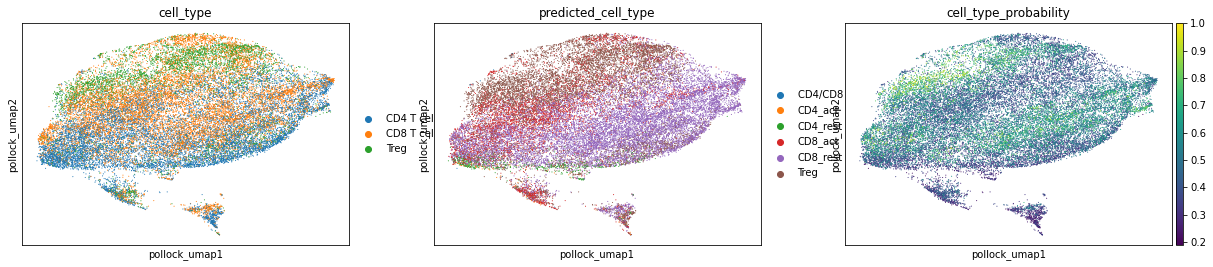

scRNAseq_cesc


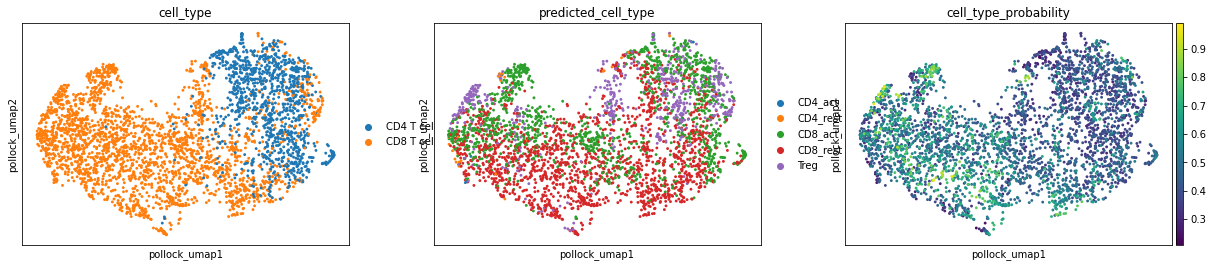

scRNAseq_hnscc


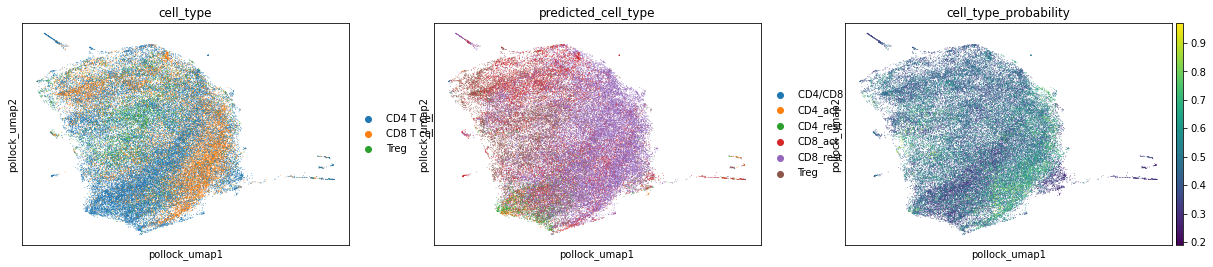

scRNAseq_melanoma


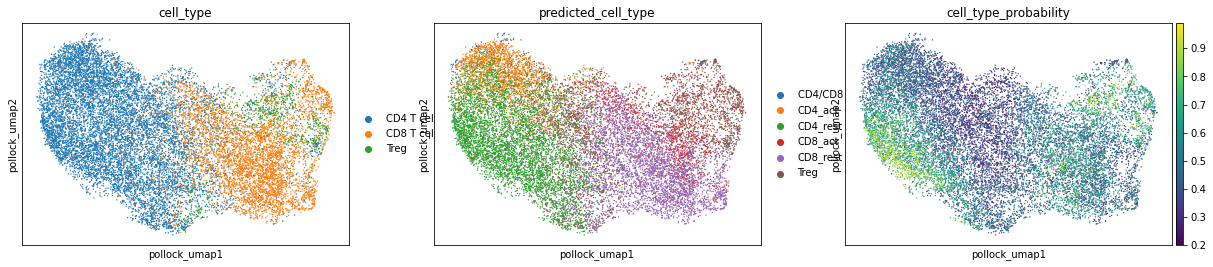

scRNAseq_pbmc


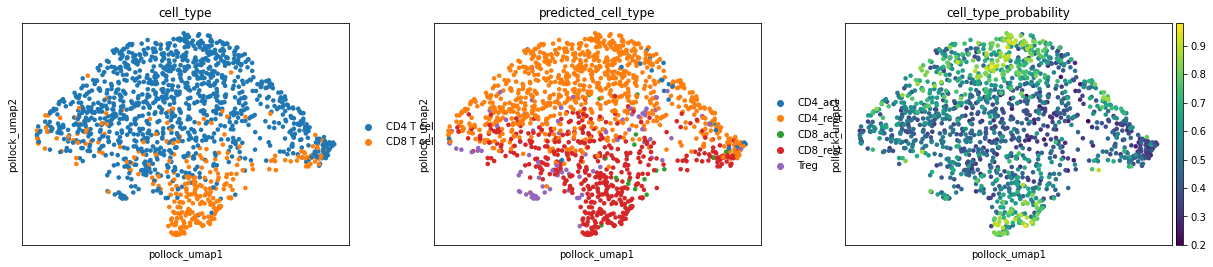

scRNAseq_pdac


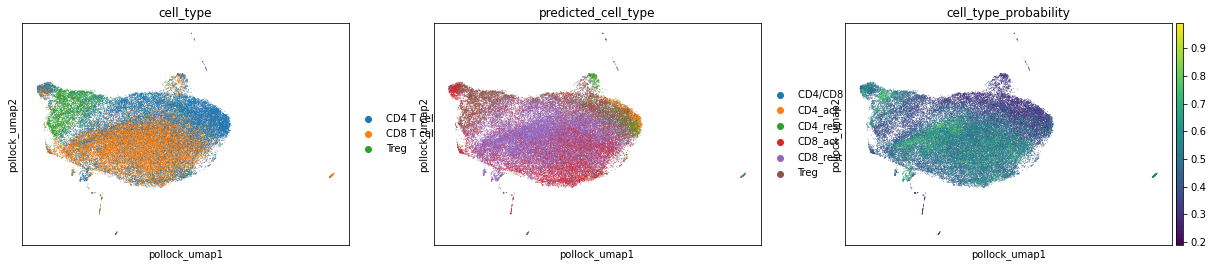

In [117]:
immune = [
#     'Basophil',
 'CD4 CTL',
 'CD4 T cell',
 'CD4 T cell activated',
 'CD4 T cell naive',
 'CD4/CD8 proliferating',
 'CD8 CTL',
 'CD8 T cell preexhausted',
#  'Macrophage',
#  'Macrophage proliferating',
 'NK cell strong',
 'NK cell weak',
#  'Plasma',
 'TRM',
 'Treg',
#  'cDC',
#  'pDC'
]
i2 = ['CD4 T cell', 'CD8 T cell', 'NK', 'Treg']
import matplotlib.pyplot as plt
# for dtype, d in data_map.items():
filtered_data_map = {}
for disease, adata in data_map['scRNAseq'].items():
    print(f'{dtype}_{disease}')
#     pdf = adata[[True if c in immune else False for c in adata.obs['predicted_cell_type']]]
#     pdf = pdf[[True if c in i2 else False for c in pdf.obs['cell_type']]]
    sc.pl.embedding(adata, basis='pollock_umap', 
            color=['cell_type', 'predicted_cell_type', 'cell_type_probability'], ncols=3)
    filtered_data_map[disease] = adata
#     plt.title(disease)
    plt.show()

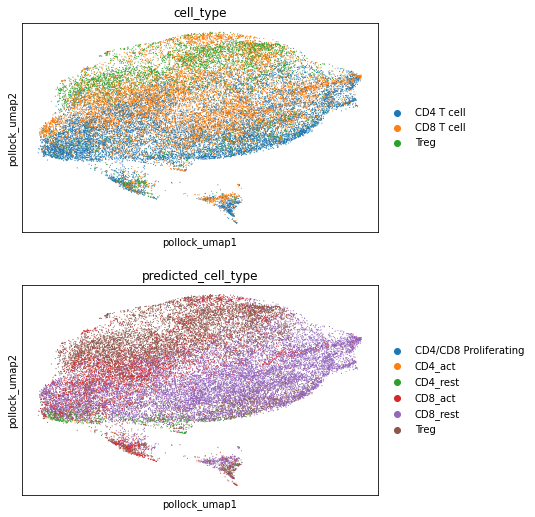

In [64]:
sc.pl.embedding(filtered_data_map['brca'], basis='pollock_umap',
                color=['cell_type', 'predicted_cell_type'],
               ncols=1)

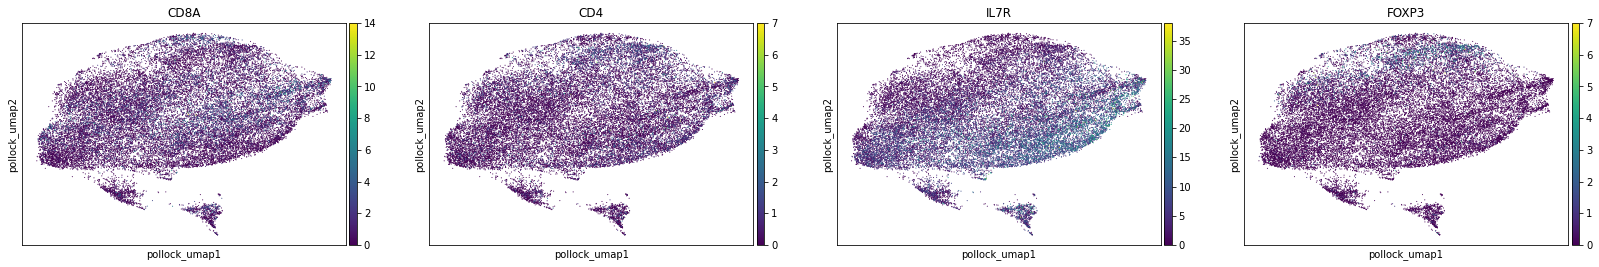

In [80]:
sc.pl.embedding(filtered_data_map['brca'], basis='pollock_umap', color=['CD8A', 'CD4', 'IL7R', 'FOXP3'])

In [ ]:
sc.pl.embedding(filtered_data_map['cesc'], basis='pollock_umap', color=['CD8A'])

In [91]:
combined = None
for disease, adata in filtered_data_map.items():
    adata.obs['disease'] = disease
    if combined is None:
        combined = adata
    else:
        combined = anndata.concat((combined, adata))
combined.obs_names_make_unique()
combined

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 156747 × 15902
    obs: 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_CD4/CD8 Proliferating', 'probability_CD4_act', 'probability_CD4_rest', 'probability_CD8_act', 'probability_CD8_rest', 'probability_Treg', 'disease'
    obsm: 'pollock_embedding', 'pollock_umap'

In [92]:
# sc.pp.neighbors(combined, use_rep='pollock_embedding')
# sc.tl.umap(combined)

In [93]:
sc.pp.normalize_total(combined, 10000)
sc.pp.log1p(combined)
# sc.pp.scale(combined)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical


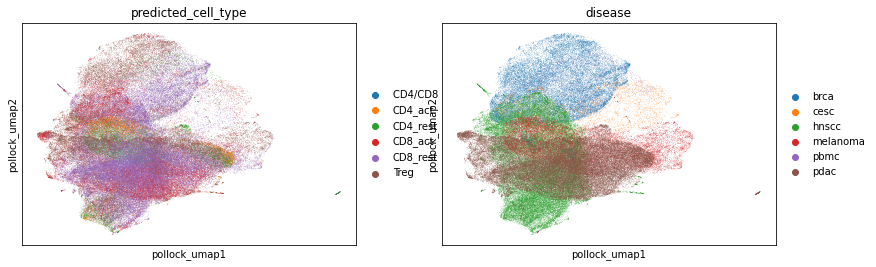

In [94]:
sc.pl.embedding(combined, basis='pollock_umap', color=['predicted_cell_type', 'disease'])

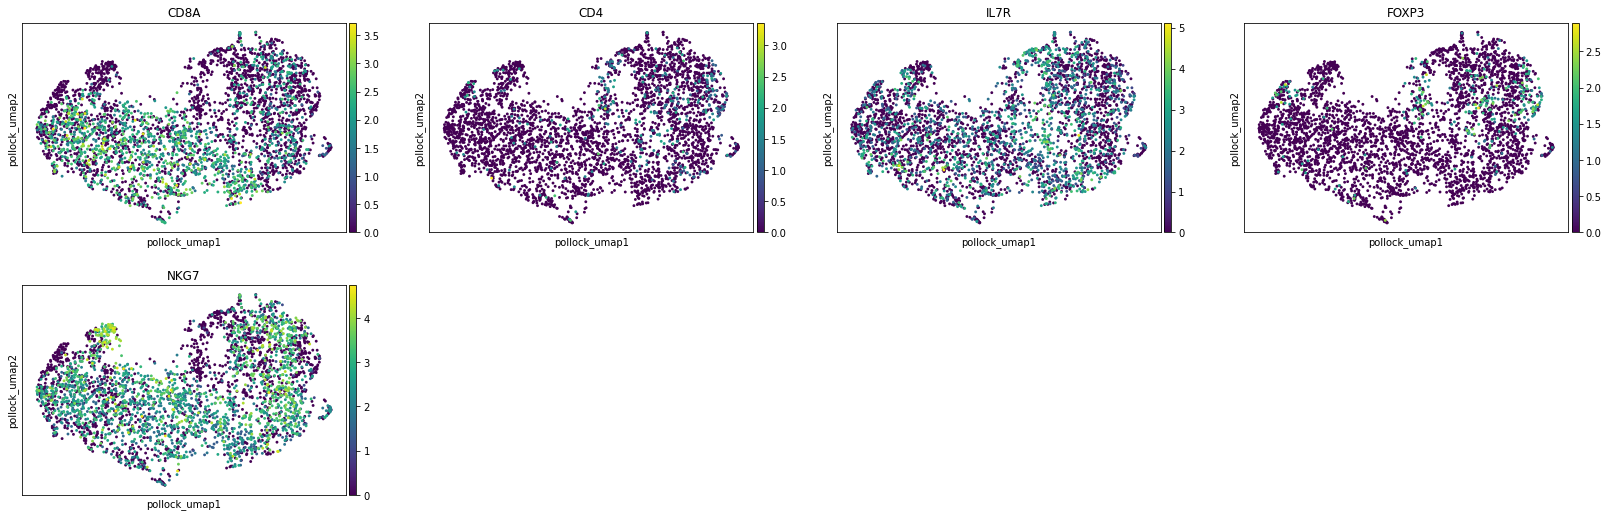

In [106]:
sc.pl.embedding(combined[combined.obs['disease']=='cesc'], basis='pollock_umap', color=['CD8A', 'CD4', 'IL7R',
                                                                                       'FOXP3', 'NKG7'])


Trying to set attribute `.uns` of view, copying.


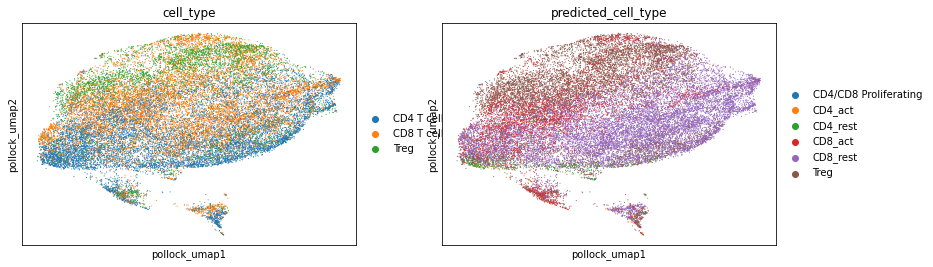

In [96]:
sc.pl.embedding(combined[combined.obs['disease']=='brca'], basis='pollock_umap', color=['cell_type',
                                                                                       'predicted_cell_type'])


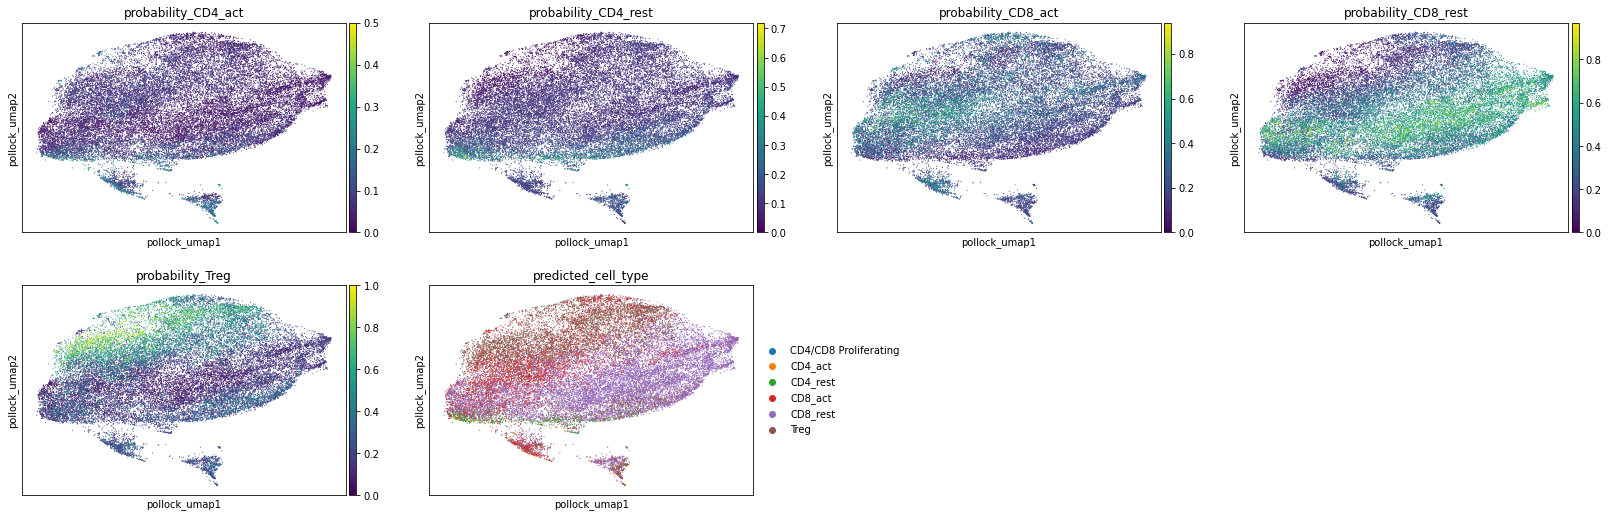

In [102]:
sc.pl.embedding(combined[combined.obs['disease']=='brca'], basis='pollock_umap', color=['probability_CD4_act',
                                                                                        'probability_CD4_rest',
                                                                                        'probability_CD8_act',
                                                                                        'probability_CD8_rest',
                                                                                        'probability_Treg',
                                                                                       'predicted_cell_type'])


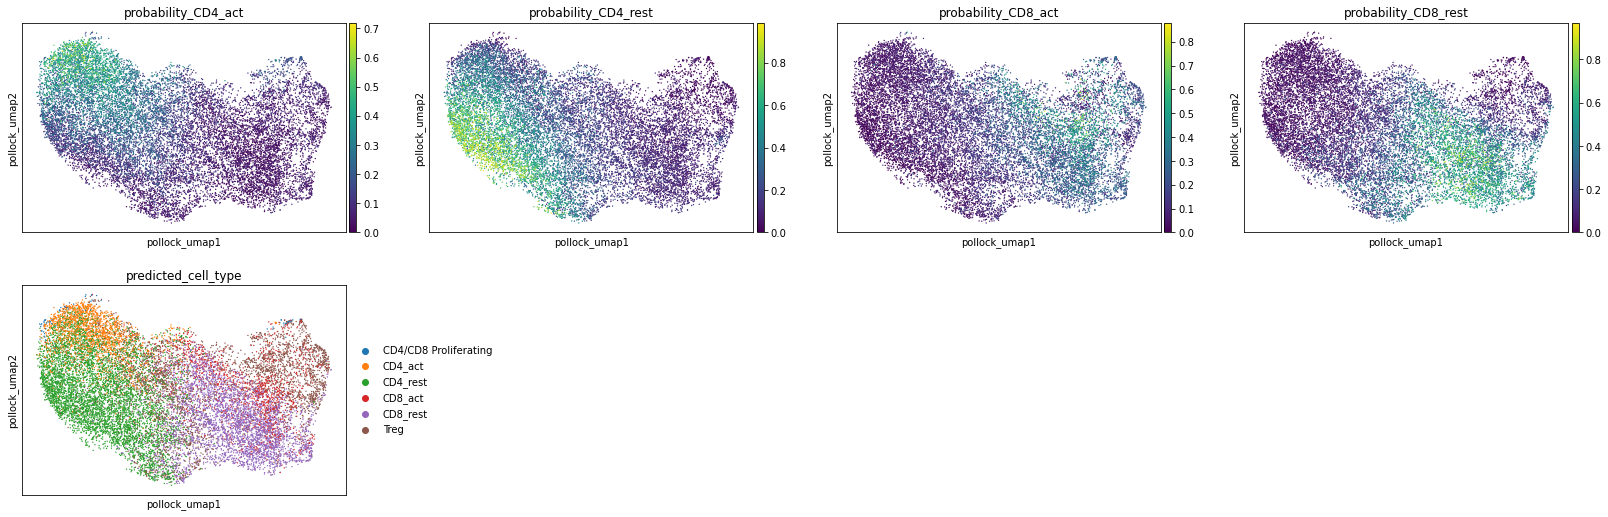

In [100]:
sc.pl.embedding(combined[combined.obs['disease']=='melanoma'], basis='pollock_umap', color=['probability_CD4_act',
                                                                                        'probability_CD4_rest',
                                                                                        'probability_CD8_act',
                                                                                        'probability_CD8_rest',
                                                                                        
                                                                                       'predicted_cell_type'])


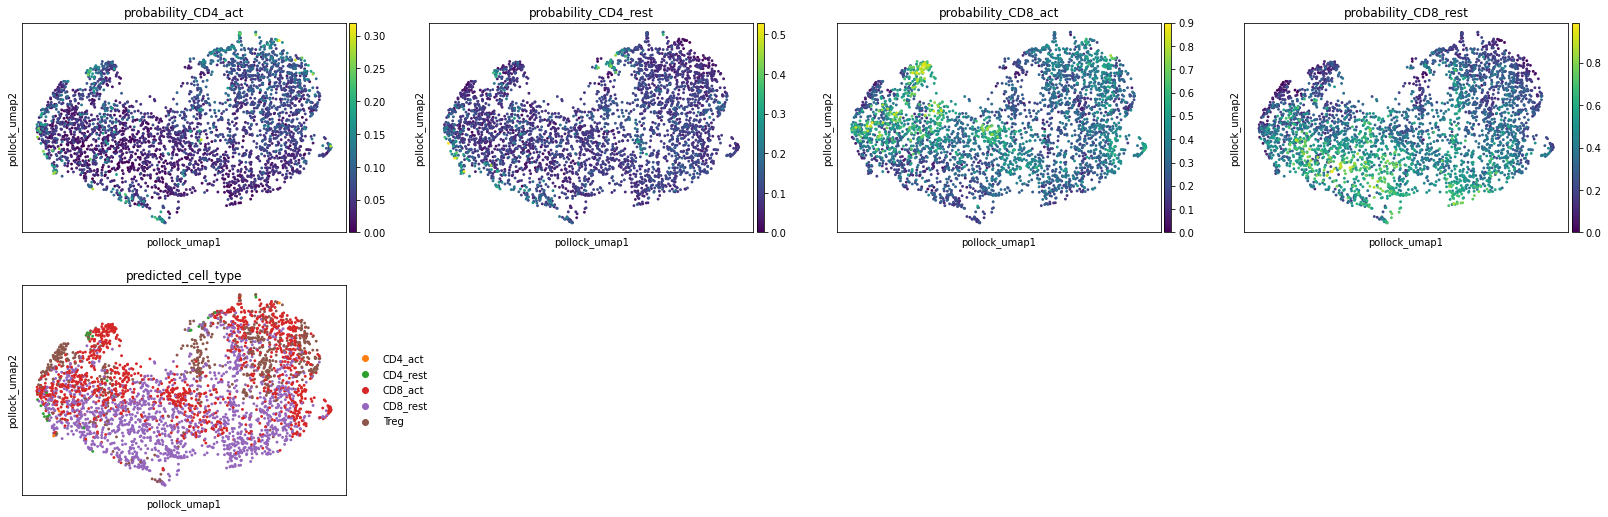

In [105]:
sc.pl.embedding(combined[combined.obs['disease']=='cesc'], basis='pollock_umap', color=['probability_CD4_act',
                                                                                        'probability_CD4_rest',
                                                                                        'probability_CD8_act',
                                                                                        'probability_CD8_rest',
                                                                                        
                                                                                       'predicted_cell_type'])


In [75]:
from collections import Counter
def plot_proportion(adata, x, y, percentage=True):
    samples = sorted(set(adata.obs[x]))
    cell_types = sorted(set(adata.obs[y]))

    data = []
    for s in samples:
        mini = adata.obs[adata.obs[x]==s]
        counts = Counter(mini[y])
        for c in cell_types:
            data.append([s, c, counts.get(c, 0)/mini.shape[0] if percentage else counts.get(c, 0)])
    df = pd.DataFrame(data=data)
    df.columns = [x, y, 'fraction' if percentage else 'count']

    return alt.Chart(df).mark_bar().encode(
        x=x,
        y='fraction' if percentage else 'count',
        color=y
    )
plot_proportion(combined, 'disease', 'predicted_cell_type')

alt.Chart(...)

In [68]:
to_explained = {}
from pollock.models.model import balancedish_training_generator
for disease, adata in filtered_data_map.items():
    explain, rest = balancedish_training_generator(adata, cell_type_key='predicted_cell_type',
                                                   n_per_cell_type=50, oversample=False,
                                        split=1.)
    background, _ = balancedish_training_generator(rest, cell_type_key='predicted_cell_type', n_per_cell_type=10,
                                                   oversample=False,
                                               split=1.)
    print(disease, explain.shape)
    w = explain_predictions(explain.copy(), background.copy(), module_fp, prediction_key='predicted_cell_type')
    to_explained[disease] = w


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


brca (274, 27131)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-06 10:56:38,051 40638 genes in training set are missing from prediction set
2021-01-06 10:56:38,784 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-06 10:56:38,881 40638 genes in training set are missing from prediction set
2021-01-06 10:56:41,301 40638 genes in training set are missing from prediction set
2021-01-06 10:56:43,461 (274, 60725)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


cesc (188, 22928)


KeyboardInterrupt: 

In [30]:
to_explained.keys()

dict_keys(['brca', 'cesc', 'hnscc', 'melanoma', 'pbmc', 'pdac'])

In [107]:
to_explained['brca']

KLHL11  CTD-3154N5.2  KRT13  SNORD116-21  \
cell_id                                                                      
_HT062B1_S1PA_AAGATAGAGAAGGCTC-1     0.0           0.0    0.0          0.0   
_HT062B1_S1PA_ACTTTGTGTGATCATC-1     0.0           0.0    0.0          0.0   
_HT062B1_S1PA_AGACCATCACAATTCG-1     0.0           0.0    0.0          0.0   
_HT062B1_S1PA_CGAGTTAGTCGTCAGC-1     0.0           0.0    0.0          0.0   
_HT062B1_S1PA_CGCCATTGTAGGTAGC-1     0.0           0.0    0.0          0.0   
...                                  ...           ...    ...          ...   
_HT171B1_BC2_TGAGGAGTCATGCCAA-1      0.0           0.0    0.0          0.0   
_HT171B1_BC2_TTCCGGTAGTTTCGGT-1      0.0           0.0    0.0          0.0   
_HT171B1_BC2_TTCCTTCCACGAGGTA-1      0.0           0.0    0.0          0.0   
_HT171B1_BC2_TTCTGTACAAGTGTCT-1      0.0           0.0    0.0          0.0   
_HT171B1_BC2_TTGCGTCTCCGGGACT-1      0.0           0.0    0.0          0.0   

                                    AGPAT3  AC096752.1  C16orf78  AC009531.2  \
cell_id                                                                        
_HT062B1_S1PA_AAGATAGAGAAGGCTC-1  0.000693         0.0       0.0         0.0   
_HT062B1_S1PA_ACTTTGTGTGATCATC-1  0.000562         0.0       0.0         0.0   
_HT062B1_S1PA_AGACCATCACAATTCG-1  0.000894         0.0       0.0         0.0   
_HT062B1_S1PA_CGAGTTAGTCGTCAGC-1  0.000083         0.0       0.0         0.0   
_HT062B1_S1PA_CGCCATTGTAGGTAGC-1  0.000096         0.0       0.0         0.0   
...                                    ...         ...       ...         ...   
_HT171B1_BC2_TGAGGAGTCATGCCAA-1   0.000092         0.0       0.0         0.0   
_HT171B1_BC2_TTCCGGTAGTTTCGGT-1   0.000186         0.0       0.0         0.0   
_HT171B1_BC2_TTCCTTCCACGAGGTA-1   0.000128         0.0       0.0         0.0   
_HT171B1_BC2_TTCTGTACAAGTGTCT-1   0.000057         0.0       0.0         0.0   
_HT171B1_BC2_TTGCGTCTCCGGGACT-1   0.000185         0.0       0.0         0.0   

                                  LINC00609  RP11-212D3.2  ...  RP11-294J22.5  \
cell_id                                                    ...                  
_HT062B1_S1PA_AAGATAGAGAAGGCTC-1        0.0           0.0  ...            0.0   
_HT062B1_S1PA_ACTTTGTGTGATCATC-1        0.0           0.0  ...            0.0   
_HT062B1_S1PA_AGACCATCACAATTCG-1        0.0           0.0  ...            0.0   
_HT062B1_S1PA_CGAGTTAGTCGTCAGC-1        0.0           0.0  ...            0.0   
_HT062B1_S1PA_CGCCATTGTAGGTAGC-1        0.0           0.0  ...            0.0   
...                                     ...           ...  ...            ...   
_HT171B1_BC2_TGAGGAGTCATGCCAA-1         0.0           0.0  ...            0.0   
_HT171B1_BC2_TTCCGGTAGTTTCGGT-1         0.0           0.0  ...            0.0   
_HT171B1_BC2_TTCCTTCCACGAGGTA-1         0.0           0.0  ...            0.0   
_HT171B1_BC2_TTCTGTACAAGTGTCT-1         0.0           0.0  ...            0.0   
_HT171B1_BC2_TTGCGTCTCCGGGACT-1         0.0           0.0  ...            0.0   

                                  MXRA5Y  Y_RNA-783  RP11-706D8.3      HEXA  \
cell_id                                                                       
_HT062B1_S1PA_AAGATAGAGAAGGCTC-1     0.0        0.0           0.0  0.000018   
_HT062B1_S1PA_ACTTTGTGTGATCATC-1     0.0        0.0           0.0  0.001505   
_HT062B1_S1PA_AGACCATCACAATTCG-1     0.0        0.0           0.0  0.000009   
_HT062B1_S1PA_CGAGTTAGTCGTCAGC-1     0.0        0.0           0.0  0.000032   
_HT062B1_S1PA_CGCCATTGTAGGTAGC-1     0.0        0.0           0.0  0.000016   
...                                  ...        ...           ...       ...   
_HT171B1_BC2_TGAGGAGTCATGCCAA-1      0.0        0.0           0.0  0.000031   
_HT171B1_BC2_TTCCGGTAGTTTCGGT-1      0.0        0.0           0.0  0.000038   
_HT171B1_BC2_TTCCTTCCACGAGGTA-1      0.0        0.0           0.0  0.000148   
_HT171B1_BC2_TTCTGTACAAGTGTCT-1      0.0        0.0    

In [32]:
import anndata

In [108]:
explain = None
adatas = []
for k, df in to_explained.items():
    og = filtered_data_map[k]
    og = og[df.index].copy()
    new = anndata.AnnData(X=df.values, obs=og.obs)
    new.var.index = df.columns
    new.obs['disease'] = k
    adatas.append(new)
    if explain is None:
        explain = new
    else:
        explain = anndata.concat((explain, new))

explain
    

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 274 × 60725
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'Bulk_PAM50', 'doublet_score', 'predicted_doublet', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_CD4/CD8 Proliferating', 'probability_CD4_act', 'probability_CD4_rest', 'probability_CD8_act', 'probability_CD8_rest', 'probability_Treg', 'disease'

In [109]:
explain.write_h5ad(os.path.join(DATA_DIR, 'explain_panimmune.h5ad'))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical


In [110]:
for adata in adatas: adata.obs['ingest_label'] = adata.obs['predicted_cell_type'].to_list()
main = adatas[0].copy()
# sc.pp.scale(main)
sc.pp.neighbors(main)
sc.pp.pca(main)
sc.tl.umap(main)

ls = [main]
for adata in adatas[1:]:
    ls.append(sc.tl.ingest(adata.copy(), main, obs='ingest_label', inplace=False))

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [111]:
main = anndata.concat(ls)
main

AnnData object with n_obs × n_vars = 274 × 60725
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'Bulk_PAM50', 'doublet_score', 'predicted_doublet', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_CD4/CD8 Proliferating', 'probability_CD4_act', 'probability_CD4_rest', 'probability_CD8_act', 'probability_CD8_rest', 'probability_Treg', 'disease', 'ingest_label'
    obsm: 'X_pca', 'X_umap'

In [112]:
feature_adata = explain.copy()

sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1.)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 274 × 60725
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'Bulk_PAM50', 'doublet_score', 'predicted_doublet', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_CD4/CD8 Proliferating', 'probability_CD4_act', 'probability_CD4_rest', 'probability_CD8_act', 'probability_CD8_rest', 'probability_Treg', 'disease', 'ingest_label', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'ingest_label' as categorical


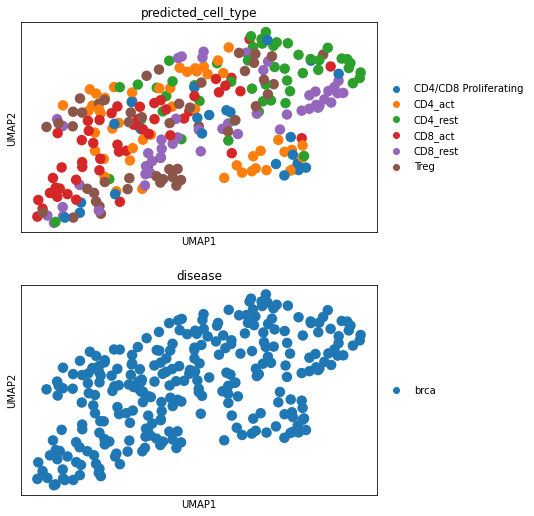

In [113]:
sc.pl.umap(main, color=['predicted_cell_type', 'disease'], ncols=1)

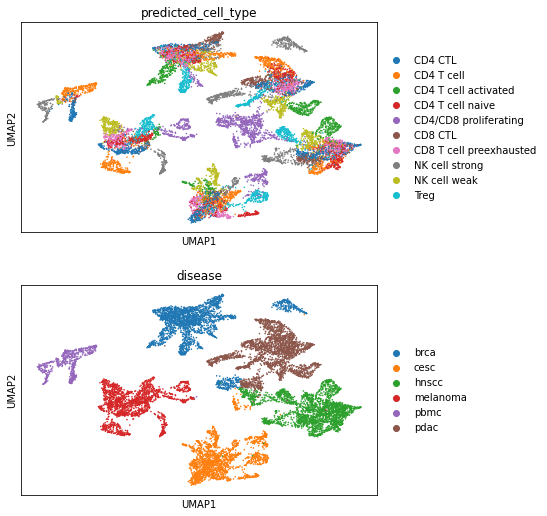

In [37]:
sc.pl.umap(feature_adata, color=['predicted_cell_type', 'disease'], ncols=1)

In [114]:
marker_genes = {
#     'Basophil': ['IL3RA'],
    'T cell': ['CD3G', 'CD3D', 'CD8A'],
#     'Memory': [''],
    'Activated': ['CD69', 'CD28'],
    'Naive': ['IL7R'],
    'Effector': ['GZMA'],
    'Memory': ['CX3CR1'],
    'Regulatory': ['FOXP3'],
    'Exausted': ['PDCD1'],
    'Proliferating': ['MKI67', 'TOP2A'],
#     'nk': ['GNLY'],
#     'nk strong': ['FCGR3A', 'SPON2', 'KLRF1'],
    'NK': ['GNLY', 'CD7'],
    'NK - Strong': ['NKG7'],
    'NK - Weak': ['NCAM1'],
    'Macrophage': ['CD14', 'FCGR3A', 'LYZ'],
    'cDC': ['BATF3','IDO1'],
    'pDC': ['IL3RA'],
    'Plasma': ['SDC1'],
#     'Endothelial': ['PECAM1'],
#     'Fibroblast': ['COL1A1',
# 'SFRP2',
# 'COL3A1',
# 'COL5A1',
# 'COL12A1',
# 'EMILIN1',
# 'LUM',
# 'MMP2',
# 'TNC',
# 'S100A4'],
#     'Malignant': ['CDKN2A',
# 'CDKN2B',
# 'PTEN',
# 'PDGFRA',
# 'EGFR',
# 'ATRX',
# 'PIK3CA',
# 'TERT',
# 'MET'],
    
}

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'ingest_label' as categorical


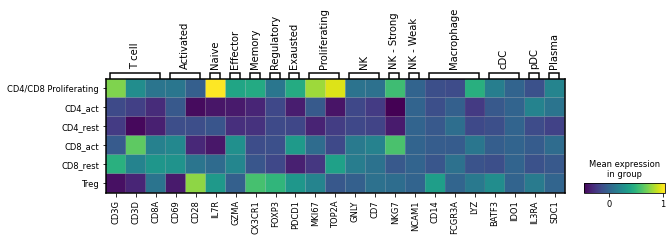

In [115]:
sc.pl.matrixplot(feature_adata[feature_adata.obs['disease']=='brca'], marker_genes, groupby='predicted_cell_type')